In [11]:
import gym
import numpy as np
import itertools
import random
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import blackjack
env = blackjack.BlackjackEnv()

# Часть первая, с блекджеком и стратегиями

In [3]:
total_rewards = 0
NUM_EPISODES = 100000
rewards = []
for _ in range(NUM_EPISODES):
    p_score, _, done = env.reset()

    while done == False:

        new_state, reward, done, desc = env.step(1)
        score, _, _ = new_state
        if score in [19, 20, 21]:
            break
    _, reward, _, _ = env.step(0)
    rewards.append(reward)
        
avg_reward = sum(rewards) / NUM_EPISODES
print(avg_reward)

-0.23462


# Q-learning

In [21]:
def play_game(env, pi):
    observation = env.reset()
    done = False
    G = 0
    while not done:
        action = pi[s2idx[observation]]
        observation, reward, done, _ = env.step(action)
        G += reward
    return G

def evaluate_pi(env, pi, n=100000, disable_tqdm=False):
    rewards = []
    for _ in tqdm(range(n), disable=disable_tqdm):
        reward = play_game(env, pi)
        rewards.append(reward)
    return np.mean(rewards)

def Q_learning_episode(env, Q, A, alpha=0.05, epsilon=0.1, gamma=1):
    s = s2idx[env.reset()]
    done = False
    get_actions_from_env = hasattr(env, 'get_actions')
        
    while not done:
        pi = np.argmax(Q, axis=1)
        if random.random() < (1 - epsilon):
            a = pi[s]
        else:
            a = random.choice(env.get_actions() if get_actions_from_env else A)
        observation, r_new, done, _ = env.step(a)
        s_new = s2idx[observation]
        Q[s, a] = Q[s, a] + alpha * (r_new + gamma * max(Q[s_new]) - Q[s, a])
        s = s_new
    return Q

def Q_learning(env, A, Q, episodes=100000, alpha=0.009, epsilon=0.85, gamma=1, disable_tqdm=False):
    for _ in tqdm(range(episodes), disable=disable_tqdm):
        Q = Q_learning_episode(env=env, Q=Q, A=A, alpha=alpha, epsilon=epsilon, gamma=gamma)
    return Q

In [ ]:
A = (0, 1)
S = list(itertools.product(range(4, 32), range(1, 11), (True, False)))
S = [s for s in S if not s[2] or (s[2] and 12 <= s[0] <= 21)]
s2idx = {state: i for i, state in enumerate(S)}
Q = np.zeros((len(S), len(A)))
Q = Q_learning(env, A, Q, episodes=100000, alpha=0.02, epsilon=0.1)
reward_mean = evaluate_pi(env, np.argmax(Q, axis=1), n=500000)
reward_mean

In [24]:
for epsilon in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    tries = 5
    reward = 0
    for i in range(tries):
        Q = np.zeros((len(S), len(A)))
        Q = Q_learning(env, A, Q, episodes=100000, alpha=0.00005, epsilon=epsilon, disable_tqdm=True)
        reward += evaluate_pi(env, np.argmax(Q, axis=1), disable_tqdm=True)
    print(f'epsilon: {epsilon}, reward: {(reward / tries)}')

epsilon: 0.2, reward: -0.07456
epsilon: 0.3, reward: -0.072864
epsilon: 0.4, reward: -0.075812
epsilon: 0.5, reward: -0.068654
epsilon: 0.6, reward: -0.06691
epsilon: 0.7, reward: -0.05847800000000001
epsilon: 0.8, reward: -0.052544
epsilon: 0.9, reward: -0.05333
epsilon: 1.0, reward: -0.051886


In [26]:
for alpha in [0.0001, 0.0002, 0.0003, 0.0004, 0.0005]:
    tries = 5
    reward = 0
    for i in range(tries):
        Q = np.zeros((len(S), len(A)))
        Q = Q_learning(env, A, Q, episodes=100000, alpha=alpha, epsilon=1.0, disable_tqdm=True)
        reward += evaluate_pi(env, np.argmax(Q, axis=1), disable_tqdm=True)
    print(f'alpha: {alpha}, reward: {(reward / tries)}')

alpha: 0.0001, reward: -0.054504
alpha: 0.0002, reward: -0.049256
alpha: 0.0003, reward: -0.052258000000000006
alpha: 0.0004, reward: -0.05494400000000001
alpha: 0.0005, reward: -0.053223999999999994


In [33]:
def plot_learinig(env, A, alpha, epsilon, episodes=1000, n_experiments=50, n_eval=100):

    Q_arr = [np.zeros((len(S), len(A)))] * n_experiments
    pi_arr = [np.argmax(Q, axis=1) for Q in Q_arr]
    results = []

    episode_results = []
    episode_nums = []

    for episode in tqdm(range(episodes)):
        experiments_result = []
        for i in range(n_experiments):
            Q_arr[i] = Q_learning_episode(env, Q_arr[i], A, alpha=alpha, epsilon=epsilon)
            pi_arr[i] = np.argmax(Q_arr[i], axis=1)
            experiments_result.append(evaluate_pi(env, pi_arr[i], n=n_eval, disable_tqdm=True))

        episode_results.append(np.mean(experiments_result))
        episode_nums.append(episode)

    plt.figure(figsize=(16, 8))
    plt.plot(episode_nums, episode_results)
    plt.grid()
    plt.xlabel('episods')
    plt.ylabel('reward')
    plt.show()




  0%|          | 0/1000 [00:00<?, ?it/s]


  0%|          | 1/1000 [00:00<06:23,  2.61it/s]


  0%|          | 2/1000 [00:00<06:17,  2.65it/s]


  0%|          | 3/1000 [00:01<06:15,  2.65it/s]


  0%|          | 4/1000 [00:01<06:08,  2.70it/s]


  0%|          | 5/1000 [00:01<06:35,  2.52it/s]


  1%|          | 6/1000 [00:02<06:22,  2.60it/s]


  1%|          | 7/1000 [00:02<06:30,  2.54it/s]


  1%|          | 8/1000 [00:03<06:39,  2.49it/s]


  1%|          | 9/1000 [00:03<06:25,  2.57it/s]


  1%|          | 10/1000 [00:03<06:22,  2.59it/s]


  1%|          | 11/1000 [00:04<06:48,  2.42it/s]


  1%|          | 12/1000 [00:04<06:37,  2.48it/s]


  1%|▏         | 13/1000 [00:05<06:24,  2.57it/s]


  1%|▏         | 14/1000 [00:05<06:17,  2.61it/s]


  2%|▏         | 15/1000 [00:05<06:41,  2.45it/s]


  2%|▏         | 16/1000 [00:06<06:34,  2.49it/s]


  2%|▏         | 17/1000 [00:06<06:34,  2.49it/s]


  2%|▏         | 18/1000 [00:07<06:27,  2.53it/s]


  2%|▏         | 19/1000 [0

 13%|█▎        | 134/1000 [00:52<05:45,  2.51it/s]


 14%|█▎        | 135/1000 [00:52<05:35,  2.58it/s]


 14%|█▎        | 136/1000 [00:53<05:28,  2.63it/s]


 14%|█▎        | 137/1000 [00:53<05:26,  2.65it/s]


 14%|█▍        | 138/1000 [00:53<05:22,  2.67it/s]


 14%|█▍        | 139/1000 [00:54<05:20,  2.69it/s]


 14%|█▍        | 140/1000 [00:54<05:18,  2.70it/s]


 14%|█▍        | 141/1000 [00:55<05:16,  2.71it/s]


 14%|█▍        | 142/1000 [00:55<05:14,  2.73it/s]


 14%|█▍        | 143/1000 [00:55<05:12,  2.74it/s]


 14%|█▍        | 144/1000 [00:56<05:11,  2.75it/s]


 14%|█▍        | 145/1000 [00:56<05:12,  2.74it/s]


 15%|█▍        | 146/1000 [00:56<05:11,  2.74it/s]


 15%|█▍        | 147/1000 [00:57<05:11,  2.73it/s]


 15%|█▍        | 148/1000 [00:57<05:11,  2.73it/s]


 15%|█▍        | 149/1000 [00:57<05:13,  2.72it/s]


 15%|█▌        | 150/1000 [00:58<05:12,  2.72it/s]


 15%|█▌        | 151/1000 [00:58<05:46,  2.45it/s]


 15%|█▌        | 152/1000 [00:59<05:35,  2.53i

 27%|██▋       | 266/1000 [01:44<04:32,  2.70it/s]


 27%|██▋       | 267/1000 [01:44<04:31,  2.70it/s]


 27%|██▋       | 268/1000 [01:45<05:11,  2.35it/s]


 27%|██▋       | 269/1000 [01:45<05:02,  2.42it/s]


 27%|██▋       | 270/1000 [01:46<05:36,  2.17it/s]


 27%|██▋       | 271/1000 [01:46<05:16,  2.30it/s]


 27%|██▋       | 272/1000 [01:47<05:00,  2.42it/s]


 27%|██▋       | 273/1000 [01:47<04:56,  2.45it/s]


 27%|██▋       | 274/1000 [01:47<04:49,  2.51it/s]


 28%|██▊       | 275/1000 [01:48<04:44,  2.55it/s]


 28%|██▊       | 276/1000 [01:48<04:38,  2.60it/s]


 28%|██▊       | 277/1000 [01:49<04:35,  2.62it/s]


 28%|██▊       | 278/1000 [01:49<04:31,  2.66it/s]


 28%|██▊       | 279/1000 [01:49<04:28,  2.68it/s]


 28%|██▊       | 280/1000 [01:50<04:29,  2.67it/s]


 28%|██▊       | 281/1000 [01:50<04:26,  2.70it/s]


 28%|██▊       | 282/1000 [01:50<04:26,  2.69it/s]


 28%|██▊       | 283/1000 [01:51<04:25,  2.70it/s]


 28%|██▊       | 284/1000 [01:51<04:25,  2.70i

 40%|███▉      | 398/1000 [02:38<03:51,  2.60it/s]


 40%|███▉      | 399/1000 [02:39<03:50,  2.61it/s]


 40%|████      | 400/1000 [02:39<03:49,  2.62it/s]


 40%|████      | 401/1000 [02:39<03:47,  2.64it/s]


 40%|████      | 402/1000 [02:40<03:46,  2.64it/s]


 40%|████      | 403/1000 [02:40<03:47,  2.63it/s]


 40%|████      | 404/1000 [02:41<03:42,  2.67it/s]


 40%|████      | 405/1000 [02:41<03:46,  2.63it/s]


 41%|████      | 406/1000 [02:41<03:49,  2.59it/s]


 41%|████      | 407/1000 [02:42<03:47,  2.60it/s]


 41%|████      | 408/1000 [02:42<03:49,  2.58it/s]


 41%|████      | 409/1000 [02:43<03:47,  2.60it/s]


 41%|████      | 410/1000 [02:43<03:47,  2.60it/s]


 41%|████      | 411/1000 [02:43<03:46,  2.60it/s]


 41%|████      | 412/1000 [02:44<03:45,  2.61it/s]


 41%|████▏     | 413/1000 [02:44<03:42,  2.64it/s]


 41%|████▏     | 414/1000 [02:44<03:44,  2.61it/s]


 42%|████▏     | 415/1000 [02:45<03:44,  2.60it/s]


 42%|████▏     | 416/1000 [02:45<03:45,  2.59i

 53%|█████▎    | 530/1000 [03:32<03:10,  2.47it/s]


 53%|█████▎    | 531/1000 [03:32<03:07,  2.50it/s]


 53%|█████▎    | 532/1000 [03:33<03:03,  2.55it/s]


 53%|█████▎    | 533/1000 [03:33<03:18,  2.35it/s]


 53%|█████▎    | 534/1000 [03:34<03:11,  2.43it/s]


 54%|█████▎    | 535/1000 [03:34<03:06,  2.49it/s]


 54%|█████▎    | 536/1000 [03:34<03:04,  2.51it/s]


 54%|█████▎    | 537/1000 [03:35<03:04,  2.51it/s]


 54%|█████▍    | 538/1000 [03:35<03:02,  2.53it/s]


 54%|█████▍    | 539/1000 [03:35<03:02,  2.52it/s]


 54%|█████▍    | 540/1000 [03:36<03:04,  2.50it/s]


 54%|█████▍    | 541/1000 [03:36<03:12,  2.38it/s]


 54%|█████▍    | 542/1000 [03:37<03:09,  2.41it/s]


 54%|█████▍    | 543/1000 [03:37<03:06,  2.45it/s]


 54%|█████▍    | 544/1000 [03:38<03:17,  2.31it/s]


 55%|█████▍    | 545/1000 [03:38<03:13,  2.35it/s]


 55%|█████▍    | 546/1000 [03:38<03:13,  2.34it/s]


 55%|█████▍    | 547/1000 [03:39<03:09,  2.39it/s]


 55%|█████▍    | 548/1000 [03:39<03:05,  2.44i

 66%|██████▌   | 662/1000 [04:26<02:19,  2.42it/s]


 66%|██████▋   | 663/1000 [04:26<02:17,  2.44it/s]


 66%|██████▋   | 664/1000 [04:27<02:16,  2.46it/s]


 66%|██████▋   | 665/1000 [04:27<02:15,  2.47it/s]


 67%|██████▋   | 666/1000 [04:27<02:13,  2.49it/s]


 67%|██████▋   | 667/1000 [04:28<02:12,  2.52it/s]


 67%|██████▋   | 668/1000 [04:28<02:11,  2.52it/s]


 67%|██████▋   | 669/1000 [04:29<02:11,  2.52it/s]


 67%|██████▋   | 670/1000 [04:29<02:11,  2.52it/s]


 67%|██████▋   | 671/1000 [04:29<02:10,  2.52it/s]


 67%|██████▋   | 672/1000 [04:30<02:13,  2.46it/s]


 67%|██████▋   | 673/1000 [04:30<02:12,  2.47it/s]


 67%|██████▋   | 674/1000 [04:31<02:11,  2.47it/s]


 68%|██████▊   | 675/1000 [04:31<02:11,  2.47it/s]


 68%|██████▊   | 676/1000 [04:31<02:11,  2.46it/s]


 68%|██████▊   | 677/1000 [04:32<02:14,  2.40it/s]


 68%|██████▊   | 678/1000 [04:32<02:11,  2.44it/s]


 68%|██████▊   | 679/1000 [04:33<02:08,  2.49it/s]


 68%|██████▊   | 680/1000 [04:33<02:05,  2.54i

 79%|███████▉  | 794/1000 [05:18<01:20,  2.54it/s]


 80%|███████▉  | 795/1000 [05:18<01:19,  2.57it/s]


 80%|███████▉  | 796/1000 [05:18<01:18,  2.59it/s]


 80%|███████▉  | 797/1000 [05:19<01:19,  2.55it/s]


 80%|███████▉  | 798/1000 [05:19<01:20,  2.52it/s]


 80%|███████▉  | 799/1000 [05:20<01:19,  2.53it/s]


 80%|████████  | 800/1000 [05:20<01:19,  2.50it/s]


 80%|████████  | 801/1000 [05:20<01:18,  2.52it/s]


 80%|████████  | 802/1000 [05:21<01:18,  2.54it/s]


 80%|████████  | 803/1000 [05:21<01:17,  2.54it/s]


 80%|████████  | 804/1000 [05:22<01:18,  2.50it/s]


 80%|████████  | 805/1000 [05:22<01:17,  2.51it/s]


 81%|████████  | 806/1000 [05:22<01:15,  2.56it/s]


 81%|████████  | 807/1000 [05:23<01:15,  2.57it/s]


 81%|████████  | 808/1000 [05:23<01:15,  2.53it/s]


 81%|████████  | 809/1000 [05:24<01:14,  2.56it/s]


 81%|████████  | 810/1000 [05:24<01:14,  2.54it/s]


 81%|████████  | 811/1000 [05:24<01:13,  2.58it/s]


 81%|████████  | 812/1000 [05:25<01:12,  2.58i

 93%|█████████▎| 926/1000 [06:12<00:31,  2.33it/s]


 93%|█████████▎| 927/1000 [06:12<00:31,  2.34it/s]


 93%|█████████▎| 928/1000 [06:13<00:30,  2.38it/s]


 93%|█████████▎| 929/1000 [06:13<00:29,  2.43it/s]


 93%|█████████▎| 930/1000 [06:14<00:28,  2.46it/s]


 93%|█████████▎| 931/1000 [06:14<00:28,  2.45it/s]


 93%|█████████▎| 932/1000 [06:14<00:27,  2.47it/s]


 93%|█████████▎| 933/1000 [06:15<00:26,  2.50it/s]


 93%|█████████▎| 934/1000 [06:15<00:26,  2.52it/s]


 94%|█████████▎| 935/1000 [06:16<00:26,  2.46it/s]


 94%|█████████▎| 936/1000 [06:16<00:26,  2.42it/s]


 94%|█████████▎| 937/1000 [06:16<00:25,  2.43it/s]


 94%|█████████▍| 938/1000 [06:17<00:25,  2.45it/s]


 94%|█████████▍| 939/1000 [06:17<00:24,  2.47it/s]


 94%|█████████▍| 940/1000 [06:18<00:24,  2.48it/s]


 94%|█████████▍| 941/1000 [06:18<00:23,  2.54it/s]


 94%|█████████▍| 942/1000 [06:18<00:22,  2.56it/s]


 94%|█████████▍| 943/1000 [06:19<00:22,  2.58it/s]


 94%|█████████▍| 944/1000 [06:19<00:21,  2.60i

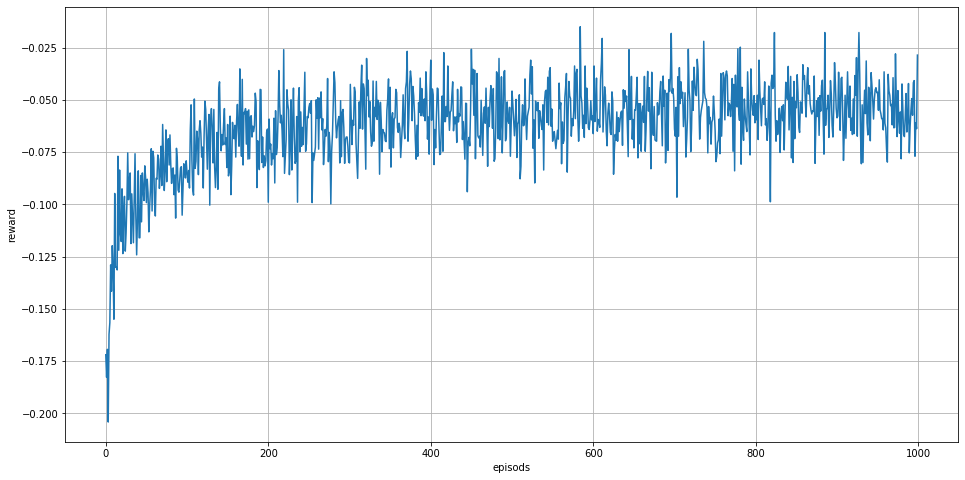

In [34]:
plot_learinig(env, A, alpha=0.0003, epsilon=1.0)

# Q-learning double

In [36]:
import blackjack_double
env = blackjack_double.BlackjackDoubleEnv(natural=True)
A = (0, 1, 2)

S = list(itertools.product(range(4, 32), range(1, 11), (True, False)))
S = [s for s in S if not s[2] or (s[2] and 12 <= s[0] <= 21)]
s2idx = {state: i for i, state in enumerate(S)}

In [41]:
Q = np.zeros((len(S), len(A)))
Q = Q_learning(env, A, Q, episodes=100000, alpha=0.0003, epsilon=1.0)
reward_mean = evaluate_pi(env, np.argmax(Q, axis=1))




  0%|          | 0/100000 [00:00<?, ?it/s]


  1%|          | 789/100000 [00:00<00:12, 7885.50it/s]


  2%|▏         | 1886/100000 [00:00<00:11, 8611.76it/s]


  3%|▎         | 2969/100000 [00:00<00:10, 9173.31it/s]


  4%|▍         | 4108/100000 [00:00<00:09, 9740.63it/s]


  5%|▌         | 5208/100000 [00:00<00:09, 10086.89it/s]


  6%|▌         | 6187/100000 [00:00<00:09, 9995.34it/s] 


  7%|▋         | 7113/100000 [00:00<00:09, 9761.06it/s]


  8%|▊         | 8037/100000 [00:00<00:10, 9194.56it/s]


  9%|▉         | 8927/100000 [00:00<00:10, 8790.59it/s]


 10%|▉         | 9911/100000 [00:01<00:09, 9079.35it/s]


 11%|█         | 10947/100000 [00:01<00:09, 9428.30it/s]


 12%|█▏        | 11947/100000 [00:01<00:09, 9591.66it/s]


 13%|█▎        | 12925/100000 [00:01<00:09, 9645.17it/s]


 14%|█▍        | 13889/100000 [00:01<00:08, 9620.01it/s]


 15%|█▍        | 14968/100000 [00:01<00:08, 9943.27it/s]


 16%|█▌        | 16107/100000 [00:01<00:08, 10335.83it/s]


 17%|█▋        |

 31%|███▏      | 31484/100000 [00:02<00:06, 11411.10it/s]


 33%|███▎      | 32644/100000 [00:03<00:05, 11466.16it/s]


 34%|███▍      | 33792/100000 [00:03<00:05, 11333.30it/s]


 35%|███▍      | 34927/100000 [00:03<00:05, 11315.96it/s]


 36%|███▌      | 36060/100000 [00:03<00:05, 11268.83it/s]


 37%|███▋      | 37241/100000 [00:03<00:05, 11425.57it/s]


 38%|███▊      | 38411/100000 [00:03<00:05, 11503.59it/s]


 40%|███▉      | 39586/100000 [00:03<00:05, 11575.04it/s]


 41%|████      | 40789/100000 [00:03<00:05, 11705.78it/s]


 42%|████▏     | 41961/100000 [00:03<00:04, 11685.84it/s]


 43%|████▎     | 43141/100000 [00:03<00:04, 11719.62it/s]


 44%|████▍     | 44314/100000 [00:04<00:04, 11704.20it/s]


 45%|████▌     | 45494/100000 [00:04<00:04, 11732.15it/s]


 47%|████▋     | 46689/100000 [00:04<00:04, 11794.29it/s]


 48%|████▊     | 47879/100000 [00:04<00:04, 11823.41it/s]


 49%|████▉     | 49062/100000 [00:04<00:04, 11722.91it/s]


 50%|█████     | 50244/100000 [00:04<00:

In [42]:
reward_mean

-0.02109

In [43]:
for epsilon in [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]:
    tries = 5
    reward = 0
    for i in range(tries):
        Q = np.zeros((len(S), len(A)))
        Q = Q_learning(env, A, Q, episodes=100000, alpha=0.0003, epsilon=epsilon, disable_tqdm=True)
        reward += evaluate_pi(env, np.argmax(Q, axis=1), disable_tqdm=True)
    print(f'epsilon: {epsilon}, reward: {(reward / tries)}')

epsilon: 0.5, reward: -0.062327
epsilon: 0.55, reward: -0.049961
epsilon: 0.6, reward: -0.059697
epsilon: 0.65, reward: -0.039067000000000005
epsilon: 0.7, reward: -0.041211000000000005
epsilon: 0.75, reward: -0.03264499999999999
epsilon: 0.8, reward: -0.035747999999999995
epsilon: 0.85, reward: -0.028665000000000003
epsilon: 0.9, reward: -0.026409
epsilon: 0.95, reward: -0.029161000000000003
epsilon: 1.0, reward: -0.027371


In [44]:
for alpha in [0.00001, 0.00002, 0.00003, 0.00004, 0.00005]:
    tries = 5
    reward = 0
    for i in range(tries):
        Q = np.zeros((len(S), len(A)))
        Q = Q_learning(env, A, Q, episodes=100000, alpha=alpha, epsilon=0.9, disable_tqdm=True)
        reward += evaluate_pi(env, np.argmax(Q, axis=1), disable_tqdm=True)
    print(f'alpha: {alpha}, reward: {(reward / tries)}')

alpha: 1e-05, reward: -0.025976
alpha: 2e-05, reward: -0.024190999999999997
alpha: 3e-05, reward: -0.026366999999999995
alpha: 4e-05, reward: -0.023583
alpha: 5e-05, reward: -0.024765


In [45]:
Q = np.zeros((len(S), len(A)))
Q = Q_learning(env, A, Q, episodes=100000, alpha=4e-05, epsilon=0.9)
reward_mean = evaluate_pi(env, np.argmax(Q, axis=1))




  0%|          | 0/100000 [00:00<?, ?it/s]


  1%|          | 975/100000 [00:00<00:10, 9743.37it/s]


  2%|▏         | 1888/100000 [00:00<00:10, 9547.97it/s]


  3%|▎         | 2813/100000 [00:00<00:10, 9456.00it/s]


  4%|▍         | 3881/100000 [00:00<00:09, 9790.59it/s]


  5%|▍         | 4967/100000 [00:00<00:09, 10088.27it/s]


  6%|▌         | 6026/100000 [00:00<00:09, 10233.19it/s]


  7%|▋         | 7028/100000 [00:00<00:09, 10165.91it/s]


  8%|▊         | 7981/100000 [00:00<00:09, 9962.83it/s] 


  9%|▉         | 8924/100000 [00:00<00:09, 9577.37it/s]


 10%|▉         | 9923/100000 [00:01<00:09, 9695.70it/s]


 11%|█         | 10967/100000 [00:01<00:08, 9907.34it/s]


 12%|█▏        | 12086/100000 [00:01<00:08, 10257.91it/s]


 13%|█▎        | 13171/100000 [00:01<00:08, 10427.80it/s]


 14%|█▍        | 14311/100000 [00:01<00:08, 10699.67it/s]


 15%|█▌        | 15454/100000 [00:01<00:07, 10907.66it/s]


 17%|█▋        | 16620/100000 [00:01<00:07, 11122.77it/s]


 18%|█▊   

 32%|███▏      | 31760/100000 [00:03<00:06, 10553.80it/s]


 33%|███▎      | 32863/100000 [00:03<00:06, 10690.49it/s]


 34%|███▍      | 33933/100000 [00:03<00:06, 10608.80it/s]


 35%|███▍      | 34997/100000 [00:03<00:06, 10616.26it/s]


 36%|███▌      | 36060/100000 [00:03<00:06, 10582.85it/s]


 37%|███▋      | 37119/100000 [00:03<00:05, 10570.63it/s]


 38%|███▊      | 38202/100000 [00:03<00:05, 10644.02it/s]


 39%|███▉      | 39395/100000 [00:03<00:05, 10997.84it/s]


 41%|████      | 40570/100000 [00:03<00:05, 11211.70it/s]


 42%|████▏     | 41695/100000 [00:03<00:05, 10866.40it/s]


 43%|████▎     | 42787/100000 [00:04<00:05, 10704.59it/s]


 44%|████▍     | 43862/100000 [00:04<00:05, 10686.94it/s]


 45%|████▍     | 44934/100000 [00:04<00:05, 10637.32it/s]


 46%|████▌     | 46000/100000 [00:04<00:05, 10424.79it/s]


 47%|████▋     | 47071/100000 [00:04<00:05, 10507.67it/s]


 48%|████▊     | 48124/100000 [00:04<00:04, 10501.52it/s]


 49%|████▉     | 49185/100000 [00:04<00:

In [46]:
reward_mean

-0.02889




  0%|          | 0/1000 [00:00<?, ?it/s]


  0%|          | 1/1000 [00:00<05:46,  2.89it/s]


  0%|          | 2/1000 [00:00<06:16,  2.65it/s]


  0%|          | 3/1000 [00:01<06:18,  2.63it/s]


  0%|          | 4/1000 [00:01<06:04,  2.73it/s]


  0%|          | 5/1000 [00:01<05:56,  2.79it/s]


  1%|          | 6/1000 [00:02<05:49,  2.84it/s]


  1%|          | 7/1000 [00:02<05:44,  2.88it/s]


  1%|          | 8/1000 [00:02<05:40,  2.91it/s]


  1%|          | 9/1000 [00:03<05:40,  2.91it/s]


  1%|          | 10/1000 [00:03<05:37,  2.93it/s]


  1%|          | 11/1000 [00:03<05:36,  2.94it/s]


  1%|          | 12/1000 [00:04<05:36,  2.93it/s]


  1%|▏         | 13/1000 [00:04<05:37,  2.93it/s]


  1%|▏         | 14/1000 [00:04<05:37,  2.92it/s]


  2%|▏         | 15/1000 [00:05<05:38,  2.91it/s]


  2%|▏         | 16/1000 [00:05<05:37,  2.91it/s]


  2%|▏         | 17/1000 [00:05<05:51,  2.79it/s]


  2%|▏         | 18/1000 [00:06<06:00,  2.73it/s]


  2%|▏         | 19/1000 [0

 13%|█▎        | 134/1000 [00:48<05:06,  2.83it/s]


 14%|█▎        | 135/1000 [00:48<05:04,  2.84it/s]


 14%|█▎        | 136/1000 [00:48<05:03,  2.85it/s]


 14%|█▎        | 137/1000 [00:49<05:06,  2.82it/s]


 14%|█▍        | 138/1000 [00:49<05:05,  2.82it/s]


 14%|█▍        | 139/1000 [00:49<05:05,  2.82it/s]


 14%|█▍        | 140/1000 [00:50<05:21,  2.67it/s]


 14%|█▍        | 141/1000 [00:50<05:17,  2.70it/s]


 14%|█▍        | 142/1000 [00:51<05:14,  2.73it/s]


 14%|█▍        | 143/1000 [00:51<05:11,  2.75it/s]


 14%|█▍        | 144/1000 [00:51<05:11,  2.75it/s]


 14%|█▍        | 145/1000 [00:52<05:09,  2.76it/s]


 15%|█▍        | 146/1000 [00:52<05:05,  2.79it/s]


 15%|█▍        | 147/1000 [00:52<05:06,  2.78it/s]


 15%|█▍        | 148/1000 [00:53<05:03,  2.80it/s]


 15%|█▍        | 149/1000 [00:53<05:05,  2.79it/s]


 15%|█▌        | 150/1000 [00:53<05:05,  2.78it/s]


 15%|█▌        | 151/1000 [00:54<05:10,  2.73it/s]


 15%|█▌        | 152/1000 [00:54<05:06,  2.76i

 27%|██▋       | 266/1000 [01:35<04:24,  2.78it/s]


 27%|██▋       | 267/1000 [01:36<04:25,  2.76it/s]


 27%|██▋       | 268/1000 [01:36<04:24,  2.77it/s]


 27%|██▋       | 269/1000 [01:37<04:23,  2.77it/s]


 27%|██▋       | 270/1000 [01:37<04:19,  2.81it/s]


 27%|██▋       | 271/1000 [01:37<04:19,  2.81it/s]


 27%|██▋       | 272/1000 [01:38<04:17,  2.82it/s]


 27%|██▋       | 273/1000 [01:38<04:16,  2.84it/s]


 27%|██▋       | 274/1000 [01:38<04:14,  2.85it/s]


 28%|██▊       | 275/1000 [01:39<04:14,  2.85it/s]


 28%|██▊       | 276/1000 [01:39<04:14,  2.85it/s]


 28%|██▊       | 277/1000 [01:39<04:13,  2.85it/s]


 28%|██▊       | 278/1000 [01:40<04:13,  2.84it/s]


 28%|██▊       | 279/1000 [01:40<04:12,  2.85it/s]


 28%|██▊       | 280/1000 [01:40<04:11,  2.86it/s]


 28%|██▊       | 281/1000 [01:41<04:12,  2.85it/s]


 28%|██▊       | 282/1000 [01:41<04:11,  2.85it/s]


 28%|██▊       | 283/1000 [01:41<04:12,  2.84it/s]


 28%|██▊       | 284/1000 [01:42<04:18,  2.77i

 40%|███▉      | 398/1000 [02:23<03:41,  2.71it/s]


 40%|███▉      | 399/1000 [02:23<03:39,  2.74it/s]


 40%|████      | 400/1000 [02:24<03:35,  2.78it/s]


 40%|████      | 401/1000 [02:24<03:31,  2.84it/s]


 40%|████      | 402/1000 [02:24<03:33,  2.80it/s]


 40%|████      | 403/1000 [02:25<03:41,  2.70it/s]


 40%|████      | 404/1000 [02:25<03:37,  2.74it/s]


 40%|████      | 405/1000 [02:25<03:33,  2.78it/s]


 41%|████      | 406/1000 [02:26<03:29,  2.83it/s]


 41%|████      | 407/1000 [02:26<03:27,  2.85it/s]


 41%|████      | 408/1000 [02:27<03:27,  2.86it/s]


 41%|████      | 409/1000 [02:27<03:27,  2.85it/s]


 41%|████      | 410/1000 [02:27<03:24,  2.88it/s]


 41%|████      | 411/1000 [02:28<03:24,  2.88it/s]


 41%|████      | 412/1000 [02:28<03:24,  2.87it/s]


 41%|████▏     | 413/1000 [02:29<04:17,  2.28it/s]


 41%|████▏     | 414/1000 [02:29<04:17,  2.27it/s]


 42%|████▏     | 415/1000 [02:29<04:03,  2.40it/s]


 42%|████▏     | 416/1000 [02:30<03:58,  2.45i

 53%|█████▎    | 530/1000 [03:13<02:57,  2.64it/s]


 53%|█████▎    | 531/1000 [03:13<02:58,  2.63it/s]


 53%|█████▎    | 532/1000 [03:14<02:55,  2.67it/s]


 53%|█████▎    | 533/1000 [03:14<03:03,  2.55it/s]


 53%|█████▎    | 534/1000 [03:14<02:58,  2.61it/s]


 54%|█████▎    | 535/1000 [03:15<02:56,  2.64it/s]


 54%|█████▎    | 536/1000 [03:15<02:51,  2.71it/s]


 54%|█████▎    | 537/1000 [03:15<02:48,  2.74it/s]


 54%|█████▍    | 538/1000 [03:16<02:46,  2.77it/s]


 54%|█████▍    | 539/1000 [03:16<02:47,  2.75it/s]


 54%|█████▍    | 540/1000 [03:17<02:55,  2.63it/s]


 54%|█████▍    | 541/1000 [03:17<02:48,  2.72it/s]


 54%|█████▍    | 542/1000 [03:17<02:58,  2.57it/s]


 54%|█████▍    | 543/1000 [03:18<02:54,  2.63it/s]


 54%|█████▍    | 544/1000 [03:18<02:48,  2.70it/s]


 55%|█████▍    | 545/1000 [03:19<02:50,  2.67it/s]


 55%|█████▍    | 546/1000 [03:19<02:52,  2.63it/s]


 55%|█████▍    | 547/1000 [03:19<02:50,  2.65it/s]


 55%|█████▍    | 548/1000 [03:20<02:49,  2.67i

 66%|██████▌   | 662/1000 [04:05<02:29,  2.26it/s]


 66%|██████▋   | 663/1000 [04:06<02:21,  2.39it/s]


 66%|██████▋   | 664/1000 [04:06<02:14,  2.50it/s]


 66%|██████▋   | 665/1000 [04:07<02:11,  2.54it/s]


 67%|██████▋   | 666/1000 [04:07<02:08,  2.60it/s]


 67%|██████▋   | 667/1000 [04:07<02:04,  2.67it/s]


 67%|██████▋   | 668/1000 [04:08<02:02,  2.71it/s]


 67%|██████▋   | 669/1000 [04:08<02:21,  2.34it/s]


 67%|██████▋   | 670/1000 [04:09<02:20,  2.35it/s]


 67%|██████▋   | 671/1000 [04:09<02:16,  2.40it/s]


 67%|██████▋   | 672/1000 [04:09<02:19,  2.36it/s]


 67%|██████▋   | 673/1000 [04:10<02:13,  2.45it/s]


 67%|██████▋   | 674/1000 [04:10<02:06,  2.58it/s]


 68%|██████▊   | 675/1000 [04:11<02:08,  2.52it/s]


 68%|██████▊   | 676/1000 [04:11<02:06,  2.56it/s]


 68%|██████▊   | 677/1000 [04:11<02:04,  2.60it/s]


 68%|██████▊   | 678/1000 [04:12<02:01,  2.64it/s]


 68%|██████▊   | 679/1000 [04:12<01:59,  2.69it/s]


 68%|██████▊   | 680/1000 [04:12<02:03,  2.59i

 79%|███████▉  | 794/1000 [04:58<01:20,  2.56it/s]


 80%|███████▉  | 795/1000 [04:58<01:20,  2.55it/s]


 80%|███████▉  | 796/1000 [04:59<01:21,  2.50it/s]


 80%|███████▉  | 797/1000 [04:59<01:21,  2.49it/s]


 80%|███████▉  | 798/1000 [04:59<01:21,  2.49it/s]


 80%|███████▉  | 799/1000 [05:00<01:20,  2.50it/s]


 80%|████████  | 800/1000 [05:00<01:19,  2.50it/s]


 80%|████████  | 801/1000 [05:01<01:19,  2.52it/s]


 80%|████████  | 802/1000 [05:01<01:17,  2.55it/s]


 80%|████████  | 803/1000 [05:01<01:17,  2.54it/s]


 80%|████████  | 804/1000 [05:02<01:16,  2.56it/s]


 80%|████████  | 805/1000 [05:02<01:17,  2.52it/s]


 81%|████████  | 806/1000 [05:03<01:16,  2.53it/s]


 81%|████████  | 807/1000 [05:03<01:17,  2.49it/s]


 81%|████████  | 808/1000 [05:04<01:21,  2.34it/s]


 81%|████████  | 809/1000 [05:04<01:18,  2.43it/s]


 81%|████████  | 810/1000 [05:04<01:17,  2.47it/s]


 81%|████████  | 811/1000 [05:05<01:16,  2.48it/s]


 81%|████████  | 812/1000 [05:05<01:13,  2.54i

 93%|█████████▎| 926/1000 [05:52<00:27,  2.69it/s]


 93%|█████████▎| 927/1000 [05:52<00:26,  2.72it/s]


 93%|█████████▎| 928/1000 [05:52<00:26,  2.73it/s]


 93%|█████████▎| 929/1000 [05:53<00:25,  2.73it/s]


 93%|█████████▎| 930/1000 [05:53<00:26,  2.66it/s]


 93%|█████████▎| 931/1000 [05:53<00:26,  2.61it/s]


 93%|█████████▎| 932/1000 [05:54<00:26,  2.58it/s]


 93%|█████████▎| 933/1000 [05:54<00:25,  2.65it/s]


 93%|█████████▎| 934/1000 [05:55<00:24,  2.73it/s]


 94%|█████████▎| 935/1000 [05:55<00:23,  2.79it/s]


 94%|█████████▎| 936/1000 [05:55<00:22,  2.78it/s]


 94%|█████████▎| 937/1000 [05:56<00:22,  2.83it/s]


 94%|█████████▍| 938/1000 [05:56<00:21,  2.86it/s]


 94%|█████████▍| 939/1000 [05:56<00:23,  2.65it/s]


 94%|█████████▍| 940/1000 [05:57<00:23,  2.52it/s]


 94%|█████████▍| 941/1000 [05:57<00:23,  2.54it/s]


 94%|█████████▍| 942/1000 [05:58<00:22,  2.56it/s]


 94%|█████████▍| 943/1000 [05:58<00:23,  2.46it/s]


 94%|█████████▍| 944/1000 [05:58<00:22,  2.48i

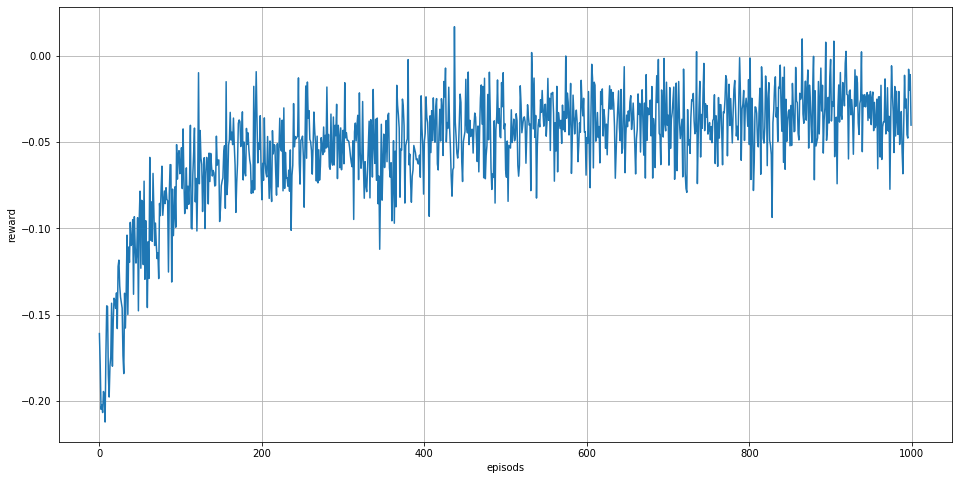

In [47]:
plot_learinig(env, A, alpha=4e-05, epsilon=0.9)

# Часть третья, в главной роли — Дастин Хоффман


In [48]:
import blackjack_double_counting
env = blackjack_double_counting.BlackjackDoubleCountingEnv(natural=True)
A = (0, 1, 2)
S = list(itertools.product(range(4, 32), range(1, 11), (True, False), range(-44, 45)))
S = [s for s in S if not s[2] or (s[2] and 12 <= s[0] <= 21)]
s2idx = {state: i for i, state in enumerate(S)}

In [49]:
Q = np.zeros((len(S), len(A)))
Q = Q_learning(env, A, Q, episodes=1000000, alpha=4e-05, epsilon=0.9)
reward_mean = evaluate_pi(env, np.argmax(Q, axis=1), n=1000000)




  0%|          | 0/1000000 [00:00<?, ?it/s]


  0%|          | 307/1000000 [00:00<05:26, 3065.89it/s]


  0%|          | 658/1000000 [00:00<05:13, 3185.39it/s]


  0%|          | 1013/1000000 [00:00<05:04, 3284.48it/s]


  0%|          | 1352/1000000 [00:00<05:01, 3315.00it/s]


  0%|          | 1688/1000000 [00:00<05:00, 3326.08it/s]


  0%|          | 2065/1000000 [00:00<04:49, 3447.82it/s]


  0%|          | 2386/1000000 [00:00<04:55, 3370.65it/s]


  0%|          | 2700/1000000 [00:00<05:03, 3283.60it/s]


  0%|          | 3053/1000000 [00:00<04:57, 3353.51it/s]


  0%|          | 3389/1000000 [00:01<04:57, 3354.31it/s]


  0%|          | 3725/1000000 [00:01<04:56, 3355.43it/s]


  0%|          | 4078/1000000 [00:01<04:52, 3405.79it/s]


  0%|          | 4430/1000000 [00:01<04:49, 3437.01it/s]


  0%|          | 4772/1000000 [00:01<04:57, 3342.97it/s]


  1%|          | 5116/1000000 [00:01<04:55, 3369.88it/s]


  1%|          | 5488/1000000 [00:01<04:46, 3466.05it/s]


  1%|    

  4%|▍         | 42396/1000000 [00:12<04:40, 3413.11it/s]


  4%|▍         | 42765/1000000 [00:12<04:34, 3488.04it/s]


  4%|▍         | 43132/1000000 [00:12<04:30, 3540.18it/s]


  4%|▍         | 43489/1000000 [00:12<04:46, 3343.67it/s]


  4%|▍         | 43828/1000000 [00:12<05:04, 3140.18it/s]


  4%|▍         | 44148/1000000 [00:12<05:06, 3116.10it/s]


  4%|▍         | 44475/1000000 [00:12<05:02, 3160.30it/s]


  4%|▍         | 44831/1000000 [00:12<04:52, 3267.53it/s]


  5%|▍         | 45192/1000000 [00:13<04:43, 3362.98it/s]


  5%|▍         | 45578/1000000 [00:13<04:32, 3497.03it/s]


  5%|▍         | 45977/1000000 [00:13<04:22, 3628.97it/s]


  5%|▍         | 46374/1000000 [00:13<04:16, 3724.64it/s]


  5%|▍         | 46762/1000000 [00:13<04:12, 3769.22it/s]


  5%|▍         | 47156/1000000 [00:13<04:09, 3817.36it/s]


  5%|▍         | 47540/1000000 [00:13<04:17, 3695.56it/s]


  5%|▍         | 47912/1000000 [00:13<04:49, 3286.88it/s]


  5%|▍         | 48251/1000000 [00:13<05

  9%|▊         | 86531/1000000 [00:24<03:54, 3896.90it/s]


  9%|▊         | 86921/1000000 [00:24<03:57, 3850.96it/s]


  9%|▊         | 87307/1000000 [00:24<04:00, 3792.29it/s]


  9%|▉         | 87710/1000000 [00:24<03:56, 3857.95it/s]


  9%|▉         | 88114/1000000 [00:24<03:53, 3909.54it/s]


  9%|▉         | 88506/1000000 [00:24<03:54, 3883.89it/s]


  9%|▉         | 88904/1000000 [00:24<03:52, 3911.43it/s]


  9%|▉         | 89299/1000000 [00:24<03:52, 3921.85it/s]


  9%|▉         | 89697/1000000 [00:25<03:51, 3937.30it/s]


  9%|▉         | 90095/1000000 [00:25<03:50, 3949.51it/s]


  9%|▉         | 90499/1000000 [00:25<03:48, 3972.66it/s]


  9%|▉         | 90897/1000000 [00:25<03:50, 3938.10it/s]


  9%|▉         | 91291/1000000 [00:25<03:50, 3934.59it/s]


  9%|▉         | 91685/1000000 [00:25<03:51, 3924.85it/s]


  9%|▉         | 92092/1000000 [00:25<03:48, 3965.23it/s]


  9%|▉         | 92493/1000000 [00:25<03:48, 3977.49it/s]


  9%|▉         | 92891/1000000 [00:25<03

 13%|█▎        | 131240/1000000 [00:36<03:44, 3867.72it/s]


 13%|█▎        | 131627/1000000 [00:36<03:46, 3831.44it/s]


 13%|█▎        | 132013/1000000 [00:36<03:46, 3839.71it/s]


 13%|█▎        | 132404/1000000 [00:36<03:44, 3859.90it/s]


 13%|█▎        | 132811/1000000 [00:36<03:41, 3919.52it/s]


 13%|█▎        | 133204/1000000 [00:36<03:41, 3909.37it/s]


 13%|█▎        | 133596/1000000 [00:36<03:43, 3869.02it/s]


 13%|█▎        | 133984/1000000 [00:36<03:44, 3863.80it/s]


 13%|█▎        | 134377/1000000 [00:36<03:42, 3882.23it/s]


 13%|█▎        | 134766/1000000 [00:37<03:44, 3861.90it/s]


 14%|█▎        | 135154/1000000 [00:37<03:43, 3864.35it/s]


 14%|█▎        | 135547/1000000 [00:37<03:42, 3881.67it/s]


 14%|█▎        | 135936/1000000 [00:37<03:42, 3882.55it/s]


 14%|█▎        | 136325/1000000 [00:37<03:43, 3865.42it/s]


 14%|█▎        | 136712/1000000 [00:37<03:43, 3860.27it/s]


 14%|█▎        | 137099/1000000 [00:37<03:43, 3859.89it/s]


 14%|█▎        | 137486/

 18%|█▊        | 176526/1000000 [00:47<03:36, 3804.36it/s]


 18%|█▊        | 176907/1000000 [00:48<03:38, 3772.16it/s]


 18%|█▊        | 177287/1000000 [00:48<03:37, 3778.97it/s]


 18%|█▊        | 177672/1000000 [00:48<03:36, 3797.70it/s]


 18%|█▊        | 178057/1000000 [00:48<03:35, 3811.89it/s]


 18%|█▊        | 178439/1000000 [00:48<03:35, 3804.29it/s]


 18%|█▊        | 178827/1000000 [00:48<03:34, 3826.00it/s]


 18%|█▊        | 179210/1000000 [00:48<03:34, 3821.59it/s]


 18%|█▊        | 179601/1000000 [00:48<03:33, 3847.37it/s]


 18%|█▊        | 179990/1000000 [00:48<03:32, 3859.51it/s]


 18%|█▊        | 180377/1000000 [00:48<03:35, 3810.94it/s]


 18%|█▊        | 180759/1000000 [00:49<03:36, 3786.30it/s]


 18%|█▊        | 181138/1000000 [00:49<03:37, 3773.40it/s]


 18%|█▊        | 181516/1000000 [00:49<03:39, 3733.19it/s]


 18%|█▊        | 181890/1000000 [00:49<03:41, 3701.27it/s]


 18%|█▊        | 182261/1000000 [00:49<03:42, 3675.33it/s]


 18%|█▊        | 182629/

 22%|██▏       | 221503/1000000 [00:59<03:23, 3830.10it/s]


 22%|██▏       | 221892/1000000 [00:59<03:22, 3847.52it/s]


 22%|██▏       | 222277/1000000 [00:59<03:23, 3824.66it/s]


 22%|██▏       | 222660/1000000 [01:00<03:23, 3823.66it/s]


 22%|██▏       | 223046/1000000 [01:00<03:22, 3833.11it/s]


 22%|██▏       | 223430/1000000 [01:00<03:22, 3827.04it/s]


 22%|██▏       | 223813/1000000 [01:00<03:23, 3807.45it/s]


 22%|██▏       | 224194/1000000 [01:00<03:26, 3761.92it/s]


 22%|██▏       | 224571/1000000 [01:00<03:27, 3729.14it/s]


 22%|██▏       | 224946/1000000 [01:00<03:27, 3734.07it/s]


 23%|██▎       | 225329/1000000 [01:00<03:25, 3760.80it/s]


 23%|██▎       | 225716/1000000 [01:00<03:24, 3791.11it/s]


 23%|██▎       | 226100/1000000 [01:01<03:23, 3804.99it/s]


 23%|██▎       | 226481/1000000 [01:01<03:26, 3750.83it/s]


 23%|██▎       | 226857/1000000 [01:01<03:34, 3609.60it/s]


 23%|██▎       | 227220/1000000 [01:01<03:50, 3358.78it/s]


 23%|██▎       | 227575/

 27%|██▋       | 266158/1000000 [01:11<03:14, 3774.42it/s]


 27%|██▋       | 266536/1000000 [01:11<03:14, 3764.73it/s]


 27%|██▋       | 266924/1000000 [01:11<03:13, 3795.74it/s]


 27%|██▋       | 267307/1000000 [01:11<03:12, 3803.93it/s]


 27%|██▋       | 267694/1000000 [01:12<03:11, 3822.26it/s]


 27%|██▋       | 268077/1000000 [01:12<03:11, 3822.77it/s]


 27%|██▋       | 268460/1000000 [01:12<03:12, 3793.35it/s]


 27%|██▋       | 268843/1000000 [01:12<03:12, 3803.85it/s]


 27%|██▋       | 269224/1000000 [01:12<03:14, 3759.81it/s]


 27%|██▋       | 269601/1000000 [01:12<03:19, 3664.85it/s]


 27%|██▋       | 269969/1000000 [01:12<03:20, 3641.37it/s]


 27%|██▋       | 270334/1000000 [01:12<03:21, 3618.46it/s]


 27%|██▋       | 270702/1000000 [01:12<03:20, 3635.10it/s]


 27%|██▋       | 271087/1000000 [01:13<03:17, 3696.98it/s]


 27%|██▋       | 271479/1000000 [01:13<03:13, 3759.65it/s]


 27%|██▋       | 271856/1000000 [01:13<03:13, 3761.28it/s]


 27%|██▋       | 272233/

 31%|███       | 310824/1000000 [01:23<03:00, 3826.55it/s]


 31%|███       | 311211/1000000 [01:23<02:59, 3837.76it/s]


 31%|███       | 311595/1000000 [01:23<03:00, 3820.83it/s]


 31%|███       | 311978/1000000 [01:23<03:00, 3810.01it/s]


 31%|███       | 312360/1000000 [01:23<03:02, 3758.05it/s]


 31%|███▏      | 312737/1000000 [01:24<03:03, 3754.55it/s]


 31%|███▏      | 313117/1000000 [01:24<03:02, 3766.97it/s]


 31%|███▏      | 313494/1000000 [01:24<03:04, 3716.84it/s]


 31%|███▏      | 313871/1000000 [01:24<03:03, 3731.48it/s]


 31%|███▏      | 314257/1000000 [01:24<03:02, 3767.29it/s]


 31%|███▏      | 314657/1000000 [01:24<02:58, 3833.62it/s]


 32%|███▏      | 315041/1000000 [01:24<03:00, 3791.39it/s]


 32%|███▏      | 315429/1000000 [01:24<02:59, 3816.34it/s]


 32%|███▏      | 315811/1000000 [01:24<03:00, 3795.13it/s]


 32%|███▏      | 316191/1000000 [01:24<03:02, 3755.35it/s]


 32%|███▏      | 316572/1000000 [01:25<03:01, 3770.68it/s]


 32%|███▏      | 316952/

 36%|███▌      | 355589/1000000 [01:35<02:49, 3806.26it/s]


 36%|███▌      | 355972/1000000 [01:35<02:48, 3812.36it/s]


 36%|███▌      | 356356/1000000 [01:35<02:48, 3819.72it/s]


 36%|███▌      | 356745/1000000 [01:35<02:47, 3839.75it/s]


 36%|███▌      | 357139/1000000 [01:35<02:46, 3867.97it/s]


 36%|███▌      | 357526/1000000 [01:35<02:46, 3854.56it/s]


 36%|███▌      | 357912/1000000 [01:36<02:46, 3851.52it/s]


 36%|███▌      | 358298/1000000 [01:36<02:46, 3852.63it/s]


 36%|███▌      | 358685/1000000 [01:36<02:46, 3857.81it/s]


 36%|███▌      | 359071/1000000 [01:36<02:46, 3857.72it/s]


 36%|███▌      | 359468/1000000 [01:36<02:44, 3890.35it/s]


 36%|███▌      | 359862/1000000 [01:36<02:43, 3904.88it/s]


 36%|███▌      | 360253/1000000 [01:36<02:45, 3858.41it/s]


 36%|███▌      | 360640/1000000 [01:36<02:46, 3834.35it/s]


 36%|███▌      | 361024/1000000 [01:36<02:48, 3801.06it/s]


 36%|███▌      | 361421/1000000 [01:36<02:45, 3849.86it/s]


 36%|███▌      | 361807/

 40%|███▉      | 399807/1000000 [01:47<02:59, 3342.40it/s]


 40%|████      | 400144/1000000 [01:47<02:59, 3349.18it/s]


 40%|████      | 400480/1000000 [01:47<02:59, 3345.97it/s]


 40%|████      | 400826/1000000 [01:47<02:57, 3374.82it/s]


 40%|████      | 401167/1000000 [01:47<02:57, 3381.35it/s]


 40%|████      | 401513/1000000 [01:47<02:55, 3402.54it/s]


 40%|████      | 401854/1000000 [01:47<02:56, 3395.64it/s]


 40%|████      | 402204/1000000 [01:48<02:54, 3422.73it/s]


 40%|████      | 402547/1000000 [01:48<02:54, 3419.68it/s]


 40%|████      | 402890/1000000 [01:48<02:56, 3391.42it/s]


 40%|████      | 403235/1000000 [01:48<02:55, 3407.57it/s]


 40%|████      | 403587/1000000 [01:48<02:53, 3439.67it/s]


 40%|████      | 403941/1000000 [01:48<02:51, 3466.96it/s]


 40%|████      | 404288/1000000 [01:48<02:53, 3424.71it/s]


 40%|████      | 404631/1000000 [01:48<02:57, 3360.86it/s]


 40%|████      | 404968/1000000 [01:48<03:10, 3124.30it/s]


 41%|████      | 405285/

 44%|████▍     | 441870/1000000 [01:59<02:24, 3849.76it/s]


 44%|████▍     | 442256/1000000 [01:59<02:26, 3819.27it/s]


 44%|████▍     | 442639/1000000 [01:59<02:28, 3759.54it/s]


 44%|████▍     | 443016/1000000 [01:59<02:28, 3751.97it/s]


 44%|████▍     | 443406/1000000 [01:59<02:26, 3794.39it/s]


 44%|████▍     | 443786/1000000 [01:59<02:26, 3789.84it/s]


 44%|████▍     | 444183/1000000 [01:59<02:24, 3840.41it/s]


 44%|████▍     | 444568/1000000 [01:59<02:24, 3841.29it/s]


 44%|████▍     | 444953/1000000 [02:00<02:25, 3816.28it/s]


 45%|████▍     | 445335/1000000 [02:00<02:27, 3765.80it/s]


 45%|████▍     | 445712/1000000 [02:00<02:27, 3745.35it/s]


 45%|████▍     | 446088/1000000 [02:00<02:27, 3748.97it/s]


 45%|████▍     | 446464/1000000 [02:00<02:27, 3749.36it/s]


 45%|████▍     | 446855/1000000 [02:00<02:25, 3794.85it/s]


 45%|████▍     | 447235/1000000 [02:00<02:25, 3793.56it/s]


 45%|████▍     | 447621/1000000 [02:00<02:24, 3811.39it/s]


 45%|████▍     | 448003/

 49%|████▊     | 485335/1000000 [02:11<02:16, 3765.44it/s]


 49%|████▊     | 485714/1000000 [02:11<02:19, 3692.14it/s]


 49%|████▊     | 486088/1000000 [02:11<02:18, 3705.20it/s]


 49%|████▊     | 486460/1000000 [02:11<02:22, 3607.39it/s]


 49%|████▊     | 486823/1000000 [02:11<02:23, 3587.04it/s]


 49%|████▊     | 487183/1000000 [02:11<02:23, 3570.41it/s]


 49%|████▉     | 487556/1000000 [02:11<02:21, 3616.22it/s]


 49%|████▉     | 487919/1000000 [02:11<02:22, 3606.17it/s]


 49%|████▉     | 488312/1000000 [02:12<02:18, 3695.71it/s]


 49%|████▉     | 488710/1000000 [02:12<02:15, 3773.68it/s]


 49%|████▉     | 489092/1000000 [02:12<02:14, 3786.84it/s]


 49%|████▉     | 489472/1000000 [02:12<02:15, 3755.38it/s]


 49%|████▉     | 489849/1000000 [02:12<02:17, 3709.66it/s]


 49%|████▉     | 490221/1000000 [02:12<02:18, 3679.06it/s]


 49%|████▉     | 490590/1000000 [02:12<02:20, 3630.75it/s]


 49%|████▉     | 490954/1000000 [02:12<02:31, 3358.44it/s]


 49%|████▉     | 491295/

 53%|█████▎    | 528754/1000000 [02:23<02:09, 3634.35it/s]


 53%|█████▎    | 529157/1000000 [02:23<02:05, 3742.61it/s]


 53%|█████▎    | 529536/1000000 [02:23<02:05, 3748.46it/s]


 53%|█████▎    | 529914/1000000 [02:23<02:09, 3625.97it/s]


 53%|█████▎    | 530280/1000000 [02:23<02:12, 3542.08it/s]


 53%|█████▎    | 530640/1000000 [02:23<02:11, 3557.78it/s]


 53%|█████▎    | 531022/1000000 [02:24<02:09, 3627.98it/s]


 53%|█████▎    | 531387/1000000 [02:24<02:13, 3509.66it/s]


 53%|█████▎    | 531740/1000000 [02:24<02:15, 3457.54it/s]


 53%|█████▎    | 532088/1000000 [02:24<02:15, 3446.66it/s]


 53%|█████▎    | 532449/1000000 [02:24<02:13, 3492.59it/s]


 53%|█████▎    | 532811/1000000 [02:24<02:12, 3529.00it/s]


 53%|█████▎    | 533198/1000000 [02:24<02:08, 3623.72it/s]


 53%|█████▎    | 533592/1000000 [02:24<02:05, 3711.52it/s]


 53%|█████▎    | 533981/1000000 [02:24<02:03, 3761.63it/s]


 53%|█████▎    | 534359/1000000 [02:25<02:05, 3720.57it/s]


 53%|█████▎    | 534732/

 57%|█████▋    | 574125/1000000 [02:35<01:46, 4004.96it/s]


 57%|█████▋    | 574531/1000000 [02:35<01:45, 4018.82it/s]


 57%|█████▋    | 574939/1000000 [02:35<01:45, 4034.38it/s]


 58%|█████▊    | 575343/1000000 [02:35<01:45, 4006.61it/s]


 58%|█████▊    | 575744/1000000 [02:35<01:47, 3964.30it/s]


 58%|█████▊    | 576141/1000000 [02:35<01:47, 3932.56it/s]


 58%|█████▊    | 576535/1000000 [02:36<01:47, 3933.38it/s]


 58%|█████▊    | 576945/1000000 [02:36<01:46, 3981.10it/s]


 58%|█████▊    | 577354/1000000 [02:36<01:45, 4010.51it/s]


 58%|█████▊    | 577770/1000000 [02:36<01:44, 4053.61it/s]


 58%|█████▊    | 578178/1000000 [02:36<01:43, 4058.65it/s]


 58%|█████▊    | 578585/1000000 [02:36<01:43, 4052.75it/s]


 58%|█████▊    | 579005/1000000 [02:36<01:42, 4093.81it/s]


 58%|█████▊    | 579415/1000000 [02:36<01:43, 4063.80it/s]


 58%|█████▊    | 579822/1000000 [02:36<01:44, 4030.45it/s]


 58%|█████▊    | 580233/1000000 [02:36<01:43, 4053.61it/s]


 58%|█████▊    | 580640/

 62%|██████▏   | 618791/1000000 [02:47<01:42, 3720.29it/s]


 62%|██████▏   | 619167/1000000 [02:47<01:42, 3702.59it/s]


 62%|██████▏   | 619578/1000000 [02:47<01:39, 3815.98it/s]


 62%|██████▏   | 619987/1000000 [02:47<01:37, 3892.57it/s]


 62%|██████▏   | 620379/1000000 [02:47<01:37, 3889.21it/s]


 62%|██████▏   | 620792/1000000 [02:47<01:35, 3957.08it/s]


 62%|██████▏   | 621190/1000000 [02:48<01:36, 3929.83it/s]


 62%|██████▏   | 621584/1000000 [02:48<01:39, 3816.21it/s]


 62%|██████▏   | 621968/1000000 [02:48<01:41, 3731.62it/s]


 62%|██████▏   | 622343/1000000 [02:48<01:43, 3638.42it/s]


 62%|██████▏   | 622711/1000000 [02:48<01:43, 3647.53it/s]


 62%|██████▏   | 623077/1000000 [02:48<01:43, 3649.61it/s]


 62%|██████▏   | 623443/1000000 [02:48<01:43, 3644.84it/s]


 62%|██████▏   | 623809/1000000 [02:48<01:43, 3628.47it/s]


 62%|██████▏   | 624173/1000000 [02:48<01:44, 3595.92it/s]


 62%|██████▏   | 624533/1000000 [02:49<01:48, 3455.69it/s]


 62%|██████▏   | 624880/

 66%|██████▌   | 662118/1000000 [02:59<01:38, 3426.87it/s]


 66%|██████▌   | 662481/1000000 [02:59<01:36, 3484.03it/s]


 66%|██████▋   | 662847/1000000 [02:59<01:35, 3534.77it/s]


 66%|██████▋   | 663217/1000000 [02:59<01:34, 3581.18it/s]


 66%|██████▋   | 663576/1000000 [02:59<01:35, 3534.26it/s]


 66%|██████▋   | 663931/1000000 [03:00<01:36, 3482.52it/s]


 66%|██████▋   | 664280/1000000 [03:00<01:39, 3381.39it/s]


 66%|██████▋   | 664645/1000000 [03:00<01:37, 3456.96it/s]


 67%|██████▋   | 665029/1000000 [03:00<01:34, 3561.98it/s]


 67%|██████▋   | 665387/1000000 [03:00<01:35, 3506.87it/s]


 67%|██████▋   | 665740/1000000 [03:00<01:37, 3433.05it/s]


 67%|██████▋   | 666128/1000000 [03:00<01:33, 3555.32it/s]


 67%|██████▋   | 666521/1000000 [03:00<01:31, 3659.13it/s]


 67%|██████▋   | 666914/1000000 [03:00<01:29, 3735.82it/s]


 67%|██████▋   | 667315/1000000 [03:01<01:27, 3812.68it/s]


 67%|██████▋   | 667721/1000000 [03:01<01:25, 3880.28it/s]


 67%|██████▋   | 668111/

 70%|███████   | 703548/1000000 [03:11<01:27, 3377.01it/s]


 70%|███████   | 703886/1000000 [03:11<01:27, 3370.82it/s]


 70%|███████   | 704240/1000000 [03:11<01:26, 3417.71it/s]


 70%|███████   | 704583/1000000 [03:11<01:26, 3416.27it/s]


 70%|███████   | 704932/1000000 [03:11<01:25, 3437.19it/s]


 71%|███████   | 705276/1000000 [03:12<01:26, 3402.96it/s]


 71%|███████   | 705619/1000000 [03:12<01:26, 3410.84it/s]


 71%|███████   | 705975/1000000 [03:12<01:25, 3452.99it/s]


 71%|███████   | 706326/1000000 [03:12<01:24, 3468.22it/s]


 71%|███████   | 706689/1000000 [03:12<01:23, 3513.81it/s]


 71%|███████   | 707044/1000000 [03:12<01:23, 3519.47it/s]


 71%|███████   | 707397/1000000 [03:12<01:24, 3474.36it/s]


 71%|███████   | 707752/1000000 [03:12<01:23, 3493.51it/s]


 71%|███████   | 708147/1000000 [03:12<01:20, 3617.81it/s]


 71%|███████   | 708521/1000000 [03:12<01:19, 3651.91it/s]


 71%|███████   | 708904/1000000 [03:13<01:18, 3702.54it/s]


 71%|███████   | 709276/

 75%|███████▍  | 747623/1000000 [03:23<01:07, 3736.71it/s]


 75%|███████▍  | 747998/1000000 [03:23<01:08, 3690.49it/s]


 75%|███████▍  | 748368/1000000 [03:23<01:08, 3671.12it/s]


 75%|███████▍  | 748745/1000000 [03:23<01:07, 3696.84it/s]


 75%|███████▍  | 749133/1000000 [03:23<01:06, 3746.13it/s]


 75%|███████▍  | 749522/1000000 [03:24<01:06, 3788.16it/s]


 75%|███████▍  | 749902/1000000 [03:24<01:06, 3761.66it/s]


 75%|███████▌  | 750279/1000000 [03:24<01:07, 3695.55it/s]


 75%|███████▌  | 750650/1000000 [03:24<01:07, 3688.98it/s]


 75%|███████▌  | 751020/1000000 [03:24<01:07, 3685.96it/s]


 75%|███████▌  | 751389/1000000 [03:24<01:09, 3581.19it/s]


 75%|███████▌  | 751748/1000000 [03:24<01:10, 3523.28it/s]


 75%|███████▌  | 752129/1000000 [03:24<01:08, 3604.19it/s]


 75%|███████▌  | 752513/1000000 [03:24<01:07, 3669.79it/s]


 75%|███████▌  | 752881/1000000 [03:24<01:14, 3299.93it/s]


 75%|███████▌  | 753219/1000000 [03:25<01:23, 2964.61it/s]


 75%|███████▌  | 753528/

 79%|███████▊  | 785281/1000000 [03:36<01:06, 3205.10it/s]


 79%|███████▊  | 785611/1000000 [03:36<01:06, 3232.80it/s]


 79%|███████▊  | 785947/1000000 [03:36<01:05, 3269.76it/s]


 79%|███████▊  | 786286/1000000 [03:36<01:04, 3301.66it/s]


 79%|███████▊  | 786617/1000000 [03:36<01:05, 3281.49it/s]


 79%|███████▊  | 786954/1000000 [03:36<01:04, 3305.59it/s]


 79%|███████▊  | 787285/1000000 [03:36<01:04, 3272.64it/s]


 79%|███████▉  | 787613/1000000 [03:36<01:05, 3258.64it/s]


 79%|███████▉  | 787940/1000000 [03:36<01:05, 3225.90it/s]


 79%|███████▉  | 788263/1000000 [03:36<01:07, 3135.41it/s]


 79%|███████▉  | 788578/1000000 [03:37<01:08, 3108.36it/s]


 79%|███████▉  | 788890/1000000 [03:37<01:08, 3097.38it/s]


 79%|███████▉  | 789201/1000000 [03:37<01:08, 3074.54it/s]


 79%|███████▉  | 789509/1000000 [03:37<01:08, 3067.03it/s]


 79%|███████▉  | 789853/1000000 [03:37<01:06, 3168.56it/s]


 79%|███████▉  | 790183/1000000 [03:37<01:05, 3206.39it/s]


 79%|███████▉  | 790505/

 82%|████████▏ | 824967/1000000 [03:48<00:51, 3427.09it/s]


 83%|████████▎ | 825314/1000000 [03:48<00:50, 3439.35it/s]


 83%|████████▎ | 825663/1000000 [03:48<00:50, 3452.24it/s]


 83%|████████▎ | 826022/1000000 [03:48<00:49, 3491.23it/s]


 83%|████████▎ | 826390/1000000 [03:48<00:48, 3545.55it/s]


 83%|████████▎ | 826746/1000000 [03:48<00:51, 3379.51it/s]


 83%|████████▎ | 827111/1000000 [03:48<00:50, 3453.86it/s]


 83%|████████▎ | 827476/1000000 [03:48<00:49, 3508.35it/s]


 83%|████████▎ | 827849/1000000 [03:48<00:48, 3571.67it/s]


 83%|████████▎ | 828235/1000000 [03:48<00:47, 3651.59it/s]


 83%|████████▎ | 828617/1000000 [03:49<00:46, 3700.04it/s]


 83%|████████▎ | 828989/1000000 [03:49<00:46, 3704.61it/s]


 83%|████████▎ | 829361/1000000 [03:49<00:46, 3636.57it/s]


 83%|████████▎ | 829730/1000000 [03:49<00:46, 3649.03it/s]


 83%|████████▎ | 830099/1000000 [03:49<00:46, 3659.38it/s]


 83%|████████▎ | 830481/1000000 [03:49<00:45, 3705.97it/s]


 83%|████████▎ | 830874/

 87%|████████▋ | 865896/1000000 [03:59<00:37, 3598.32it/s]


 87%|████████▋ | 866263/1000000 [04:00<00:36, 3619.24it/s]


 87%|████████▋ | 866626/1000000 [04:00<00:36, 3616.86it/s]


 87%|████████▋ | 867009/1000000 [04:00<00:36, 3677.54it/s]


 87%|████████▋ | 867378/1000000 [04:00<00:36, 3679.80it/s]


 87%|████████▋ | 867747/1000000 [04:00<00:36, 3648.65it/s]


 87%|████████▋ | 868124/1000000 [04:00<00:35, 3682.72it/s]


 87%|████████▋ | 868493/1000000 [04:00<00:35, 3672.41it/s]


 87%|████████▋ | 868861/1000000 [04:00<00:35, 3664.89it/s]


 87%|████████▋ | 869235/1000000 [04:00<00:35, 3686.20it/s]


 87%|████████▋ | 869606/1000000 [04:00<00:35, 3691.48it/s]


 87%|████████▋ | 869976/1000000 [04:01<00:35, 3680.43it/s]


 87%|████████▋ | 870349/1000000 [04:01<00:35, 3694.37it/s]


 87%|████████▋ | 870719/1000000 [04:01<00:35, 3669.65it/s]


 87%|████████▋ | 871087/1000000 [04:01<00:35, 3638.42it/s]


 87%|████████▋ | 871457/1000000 [04:01<00:35, 3655.32it/s]


 87%|████████▋ | 871823/

 91%|█████████ | 907428/1000000 [04:11<00:24, 3854.95it/s]


 91%|█████████ | 907814/1000000 [04:12<00:23, 3846.64it/s]


 91%|█████████ | 908206/1000000 [04:12<00:23, 3867.44it/s]


 91%|█████████ | 908610/1000000 [04:12<00:23, 3912.26it/s]


 91%|█████████ | 909013/1000000 [04:12<00:23, 3945.35it/s]


 91%|█████████ | 909408/1000000 [04:12<00:23, 3935.38it/s]


 91%|█████████ | 909802/1000000 [04:12<00:23, 3882.33it/s]


 91%|█████████ | 910191/1000000 [04:12<00:23, 3805.12it/s]


 91%|█████████ | 910573/1000000 [04:12<00:23, 3796.61it/s]


 91%|█████████ | 910954/1000000 [04:12<00:23, 3761.29it/s]


 91%|█████████ | 911331/1000000 [04:12<00:23, 3754.90it/s]


 91%|█████████ | 911707/1000000 [04:13<00:23, 3714.75it/s]


 91%|█████████ | 912079/1000000 [04:13<00:23, 3709.96it/s]


 91%|█████████ | 912451/1000000 [04:13<00:23, 3692.22it/s]


 91%|█████████▏| 912821/1000000 [04:13<00:24, 3623.75it/s]


 91%|█████████▏| 913184/1000000 [04:13<00:24, 3582.82it/s]


 91%|█████████▏| 913543/

 95%|█████████▍| 947884/1000000 [04:23<00:15, 3467.41it/s]


 95%|█████████▍| 948232/1000000 [04:24<00:15, 3447.62it/s]


 95%|█████████▍| 948578/1000000 [04:24<00:14, 3437.70it/s]


 95%|█████████▍| 948923/1000000 [04:24<00:15, 3360.49it/s]


 95%|█████████▍| 949260/1000000 [04:24<00:15, 3307.65it/s]


 95%|█████████▍| 949592/1000000 [04:24<00:15, 3238.88it/s]


 95%|█████████▍| 949917/1000000 [04:24<00:15, 3154.59it/s]


 95%|█████████▌| 950272/1000000 [04:24<00:15, 3262.65it/s]


 95%|█████████▌| 950613/1000000 [04:24<00:14, 3302.99it/s]


 95%|█████████▌| 950956/1000000 [04:24<00:14, 3338.92it/s]


 95%|█████████▌| 951291/1000000 [04:25<00:14, 3326.48it/s]


 95%|█████████▌| 951636/1000000 [04:25<00:14, 3362.41it/s]


 95%|█████████▌| 951978/1000000 [04:25<00:14, 3378.41it/s]


 95%|█████████▌| 952318/1000000 [04:25<00:14, 3382.47it/s]


 95%|█████████▌| 952657/1000000 [04:25<00:15, 3122.58it/s]


 95%|█████████▌| 952974/1000000 [04:25<00:15, 3102.23it/s]


 95%|█████████▌| 953288/

 99%|█████████▊| 987371/1000000 [04:36<00:03, 3277.18it/s]


 99%|█████████▉| 987700/1000000 [04:36<00:03, 3175.44it/s]


 99%|█████████▉| 988040/1000000 [04:36<00:03, 3238.75it/s]


 99%|█████████▉| 988391/1000000 [04:36<00:03, 3314.66it/s]


 99%|█████████▉| 988724/1000000 [04:36<00:03, 2993.98it/s]


 99%|█████████▉| 989061/1000000 [04:36<00:03, 3096.80it/s]


 99%|█████████▉| 989436/1000000 [04:36<00:03, 3266.28it/s]


 99%|█████████▉| 989791/1000000 [04:36<00:03, 3342.88it/s]


 99%|█████████▉| 990151/1000000 [04:36<00:02, 3414.98it/s]


 99%|█████████▉| 990520/1000000 [04:36<00:02, 3491.22it/s]


 99%|█████████▉| 990873/1000000 [04:37<00:02, 3333.44it/s]


 99%|█████████▉| 991211/1000000 [04:37<00:02, 3342.12it/s]


 99%|█████████▉| 991578/1000000 [04:37<00:02, 3431.06it/s]


 99%|█████████▉| 991958/1000000 [04:37<00:02, 3532.20it/s]


 99%|█████████▉| 992329/1000000 [04:37<00:02, 3583.47it/s]


 99%|█████████▉| 992697/1000000 [04:37<00:02, 3607.04it/s]


 99%|█████████▉| 993082/

  8%|▊         | 83768/1000000 [00:08<01:31, 10029.55it/s]


  8%|▊         | 84772/1000000 [00:08<01:34, 9704.23it/s] 


  9%|▊         | 85746/1000000 [00:08<01:35, 9574.07it/s]


  9%|▊         | 86722/1000000 [00:08<01:34, 9626.76it/s]


  9%|▉         | 87692/1000000 [00:08<01:34, 9648.36it/s]


  9%|▉         | 88670/1000000 [00:08<01:34, 9687.25it/s]


  9%|▉         | 89686/1000000 [00:09<01:32, 9823.16it/s]


  9%|▉         | 90670/1000000 [00:09<01:32, 9822.62it/s]


  9%|▉         | 91654/1000000 [00:09<01:40, 9053.51it/s]


  9%|▉         | 92572/1000000 [00:09<01:47, 8455.07it/s]


  9%|▉         | 93435/1000000 [00:09<01:47, 8444.88it/s]


  9%|▉         | 94390/1000000 [00:09<01:43, 8747.09it/s]


 10%|▉         | 95332/1000000 [00:09<01:41, 8936.74it/s]


 10%|▉         | 96296/1000000 [00:09<01:38, 9135.69it/s]


 10%|▉         | 97275/1000000 [00:09<01:36, 9321.07it/s]


 10%|▉         | 98291/1000000 [00:10<01:34, 9555.83it/s]


 10%|▉         | 99309/1000000 [00:10<

 20%|██        | 202878/1000000 [00:20<01:14, 10744.48it/s]


 20%|██        | 203982/1000000 [00:20<01:13, 10830.50it/s]


 21%|██        | 205066/1000000 [00:20<01:13, 10793.51it/s]


 21%|██        | 206151/1000000 [00:20<01:13, 10810.33it/s]


 21%|██        | 207233/1000000 [00:20<01:13, 10739.18it/s]


 21%|██        | 208308/1000000 [00:20<01:13, 10707.31it/s]


 21%|██        | 209390/1000000 [00:20<01:13, 10740.54it/s]


 21%|██        | 210481/1000000 [00:21<01:13, 10788.81it/s]


 21%|██        | 211561/1000000 [00:21<01:13, 10775.31it/s]


 21%|██▏       | 212652/1000000 [00:21<01:12, 10815.14it/s]


 21%|██▏       | 213789/1000000 [00:21<01:11, 10975.06it/s]


 21%|██▏       | 214888/1000000 [00:21<01:12, 10896.59it/s]


 22%|██▏       | 216003/1000000 [00:21<01:11, 10969.52it/s]


 22%|██▏       | 217123/1000000 [00:21<01:10, 11035.18it/s]


 22%|██▏       | 218227/1000000 [00:21<01:10, 11014.90it/s]


 22%|██▏       | 219376/1000000 [00:21<01:10, 11151.26it/s]


 22%|██▏

 33%|███▎      | 329062/1000000 [00:32<01:01, 10903.12it/s]


 33%|███▎      | 330155/1000000 [00:32<01:02, 10771.34it/s]


 33%|███▎      | 331238/1000000 [00:32<01:01, 10788.86it/s]


 33%|███▎      | 332319/1000000 [00:32<01:02, 10720.81it/s]


 33%|███▎      | 333393/1000000 [00:32<01:02, 10671.34it/s]


 33%|███▎      | 334461/1000000 [00:32<01:03, 10502.35it/s]


 34%|███▎      | 335513/1000000 [00:32<01:04, 10234.40it/s]


 34%|███▎      | 336539/1000000 [00:32<01:05, 10108.20it/s]


 34%|███▍      | 337552/1000000 [00:32<01:05, 10058.54it/s]


 34%|███▍      | 338560/1000000 [00:33<01:05, 10063.68it/s]


 34%|███▍      | 339574/1000000 [00:33<01:05, 10086.18it/s]


 34%|███▍      | 340584/1000000 [00:33<01:18, 8408.09it/s] 


 34%|███▍      | 341537/1000000 [00:33<01:15, 8715.20it/s]


 34%|███▍      | 342583/1000000 [00:33<01:11, 9173.69it/s]


 34%|███▍      | 343660/1000000 [00:33<01:08, 9599.84it/s]


 34%|███▍      | 344668/1000000 [00:33<01:07, 9737.89it/s]


 35%|███▍   

 45%|████▍     | 448419/1000000 [00:43<00:54, 10029.97it/s]


 45%|████▍     | 449478/1000000 [00:43<00:54, 10188.42it/s]


 45%|████▌     | 450523/1000000 [00:44<00:53, 10263.73it/s]


 45%|████▌     | 451591/1000000 [00:44<00:52, 10384.71it/s]


 45%|████▌     | 452644/1000000 [00:44<00:52, 10425.05it/s]


 45%|████▌     | 453688/1000000 [00:44<00:52, 10408.61it/s]


 45%|████▌     | 454745/1000000 [00:44<00:52, 10454.27it/s]


 46%|████▌     | 455823/1000000 [00:44<00:51, 10549.03it/s]


 46%|████▌     | 456950/1000000 [00:44<00:50, 10755.17it/s]


 46%|████▌     | 458051/1000000 [00:44<00:50, 10828.61it/s]


 46%|████▌     | 459145/1000000 [00:44<00:49, 10860.96it/s]


 46%|████▌     | 460232/1000000 [00:44<00:49, 10834.33it/s]


 46%|████▌     | 461316/1000000 [00:45<00:49, 10790.70it/s]


 46%|████▌     | 462396/1000000 [00:45<00:49, 10772.36it/s]


 46%|████▋     | 463474/1000000 [00:45<00:50, 10711.80it/s]


 46%|████▋     | 464554/1000000 [00:45<00:49, 10737.81it/s]


 47%|███

 57%|█████▋    | 567557/1000000 [00:55<00:40, 10625.12it/s]


 57%|█████▋    | 568620/1000000 [00:55<00:40, 10594.24it/s]


 57%|█████▋    | 569685/1000000 [00:55<00:40, 10609.32it/s]


 57%|█████▋    | 570747/1000000 [00:56<00:40, 10562.11it/s]


 57%|█████▋    | 571804/1000000 [00:56<00:40, 10548.22it/s]


 57%|█████▋    | 572887/1000000 [00:56<00:40, 10628.73it/s]


 57%|█████▋    | 573951/1000000 [00:56<00:40, 10573.50it/s]


 58%|█████▊    | 575009/1000000 [00:56<00:40, 10528.35it/s]


 58%|█████▊    | 576109/1000000 [00:56<00:39, 10664.09it/s]


 58%|█████▊    | 577176/1000000 [00:56<00:39, 10626.95it/s]


 58%|█████▊    | 578260/1000000 [00:56<00:39, 10687.76it/s]


 58%|█████▊    | 579330/1000000 [00:56<00:39, 10582.71it/s]


 58%|█████▊    | 580389/1000000 [00:57<00:39, 10522.31it/s]


 58%|█████▊    | 581442/1000000 [00:57<00:39, 10468.27it/s]


 58%|█████▊    | 582490/1000000 [00:57<00:40, 10416.34it/s]


 58%|█████▊    | 583532/1000000 [00:57<00:42, 9850.17it/s] 


 58%|███

 68%|██████▊   | 684812/1000000 [01:07<00:31, 10115.34it/s]


 69%|██████▊   | 685867/1000000 [01:07<00:30, 10240.85it/s]


 69%|██████▊   | 686944/1000000 [01:07<00:30, 10391.48it/s]


 69%|██████▉   | 688014/1000000 [01:07<00:29, 10480.76it/s]


 69%|██████▉   | 689064/1000000 [01:08<00:29, 10429.87it/s]


 69%|██████▉   | 690108/1000000 [01:08<00:30, 10296.49it/s]


 69%|██████▉   | 691216/1000000 [01:08<00:29, 10518.20it/s]


 69%|██████▉   | 692271/1000000 [01:08<00:29, 10526.23it/s]


 69%|██████▉   | 693325/1000000 [01:08<00:29, 10328.19it/s]


 69%|██████▉   | 694360/1000000 [01:08<00:30, 10187.33it/s]


 70%|██████▉   | 695447/1000000 [01:08<00:29, 10380.01it/s]


 70%|██████▉   | 696515/1000000 [01:08<00:28, 10465.44it/s]


 70%|██████▉   | 697564/1000000 [01:08<00:30, 9999.92it/s] 


 70%|██████▉   | 698570/1000000 [01:09<00:31, 9629.28it/s]


 70%|██████▉   | 699580/1000000 [01:09<00:30, 9764.41it/s]


 70%|███████   | 700562/1000000 [01:09<00:31, 9421.16it/s]


 70%|██████

 80%|████████  | 803660/1000000 [01:19<00:18, 10787.17it/s]


 80%|████████  | 804740/1000000 [01:19<00:18, 10556.26it/s]


 81%|████████  | 805827/1000000 [01:19<00:18, 10648.03it/s]


 81%|████████  | 806918/1000000 [01:19<00:18, 10723.97it/s]


 81%|████████  | 808059/1000000 [01:19<00:17, 10920.86it/s]


 81%|████████  | 809210/1000000 [01:20<00:17, 11090.08it/s]


 81%|████████  | 810331/1000000 [01:20<00:17, 11124.42it/s]


 81%|████████  | 811452/1000000 [01:20<00:16, 11149.07it/s]


 81%|████████▏ | 812568/1000000 [01:20<00:16, 11078.74it/s]


 81%|████████▏ | 813687/1000000 [01:20<00:16, 11110.22it/s]


 81%|████████▏ | 814799/1000000 [01:20<00:16, 11107.49it/s]


 82%|████████▏ | 815913/1000000 [01:20<00:16, 11116.39it/s]


 82%|████████▏ | 817025/1000000 [01:20<00:16, 11095.78it/s]


 82%|████████▏ | 818135/1000000 [01:20<00:16, 11083.25it/s]


 82%|████████▏ | 819248/1000000 [01:20<00:16, 11096.97it/s]


 82%|████████▏ | 820382/1000000 [01:21<00:16, 11161.72it/s]


 82%|███

 93%|█████████▎| 929254/1000000 [01:31<00:06, 10664.66it/s]


 93%|█████████▎| 930350/1000000 [01:31<00:06, 10750.53it/s]


 93%|█████████▎| 931450/1000000 [01:31<00:06, 10822.77it/s]


 93%|█████████▎| 932533/1000000 [01:31<00:06, 10820.78it/s]


 93%|█████████▎| 933616/1000000 [01:31<00:06, 10761.41it/s]


 93%|█████████▎| 934693/1000000 [01:31<00:06, 10754.15it/s]


 94%|█████████▎| 935769/1000000 [01:31<00:05, 10741.72it/s]


 94%|█████████▎| 936844/1000000 [01:31<00:05, 10725.87it/s]


 94%|█████████▍| 937935/1000000 [01:31<00:05, 10778.63it/s]


 94%|█████████▍| 939013/1000000 [01:32<00:05, 10764.97it/s]


 94%|█████████▍| 940120/1000000 [01:32<00:05, 10854.28it/s]


 94%|█████████▍| 941206/1000000 [01:32<00:05, 10838.93it/s]


 94%|█████████▍| 942307/1000000 [01:32<00:05, 10889.14it/s]


 94%|█████████▍| 943397/1000000 [01:32<00:05, 10800.89it/s]


 94%|█████████▍| 944481/1000000 [01:32<00:05, 10811.14it/s]


 95%|█████████▍| 945577/1000000 [01:32<00:05, 10854.86it/s]


 95%|███

In [50]:
reward_mean

0.012943




  0%|          | 0/1000 [00:00<?, ?it/s]


  0%|          | 1/1000 [00:00<06:24,  2.60it/s]


  0%|          | 2/1000 [00:00<06:45,  2.46it/s]


  0%|          | 3/1000 [00:01<06:42,  2.48it/s]


  0%|          | 4/1000 [00:01<06:39,  2.50it/s]


  0%|          | 5/1000 [00:02<06:36,  2.51it/s]


  1%|          | 6/1000 [00:02<06:40,  2.48it/s]


  1%|          | 7/1000 [00:02<06:45,  2.45it/s]


  1%|          | 8/1000 [00:03<06:49,  2.43it/s]


  1%|          | 9/1000 [00:03<06:47,  2.43it/s]


  1%|          | 10/1000 [00:04<06:33,  2.51it/s]


  1%|          | 11/1000 [00:04<06:26,  2.56it/s]


  1%|          | 12/1000 [00:04<06:18,  2.61it/s]


  1%|▏         | 13/1000 [00:05<06:13,  2.64it/s]


  1%|▏         | 14/1000 [00:05<06:13,  2.64it/s]


  2%|▏         | 15/1000 [00:06<06:39,  2.47it/s]


  2%|▏         | 16/1000 [00:06<06:58,  2.35it/s]


  2%|▏         | 17/1000 [00:06<06:58,  2.35it/s]


  2%|▏         | 18/1000 [00:07<06:56,  2.36it/s]


  2%|▏         | 19/1000 [0

 13%|█▎        | 134/1000 [00:52<05:58,  2.41it/s]


 14%|█▎        | 135/1000 [00:52<05:58,  2.41it/s]


 14%|█▎        | 136/1000 [00:53<06:00,  2.40it/s]


 14%|█▎        | 137/1000 [00:53<06:06,  2.36it/s]


 14%|█▍        | 138/1000 [00:54<06:08,  2.34it/s]


 14%|█▍        | 139/1000 [00:54<06:06,  2.35it/s]


 14%|█▍        | 140/1000 [00:55<06:08,  2.33it/s]


 14%|█▍        | 141/1000 [00:55<06:05,  2.35it/s]


 14%|█▍        | 142/1000 [00:55<05:57,  2.40it/s]


 14%|█▍        | 143/1000 [00:56<06:09,  2.32it/s]


 14%|█▍        | 144/1000 [00:56<06:10,  2.31it/s]


 14%|█▍        | 145/1000 [00:57<06:30,  2.19it/s]


 15%|█▍        | 146/1000 [00:57<06:27,  2.20it/s]


 15%|█▍        | 147/1000 [00:58<06:18,  2.25it/s]


 15%|█▍        | 148/1000 [00:58<06:12,  2.29it/s]


 15%|█▍        | 149/1000 [00:58<06:07,  2.31it/s]


 15%|█▌        | 150/1000 [00:59<06:07,  2.31it/s]


 15%|█▌        | 151/1000 [00:59<06:07,  2.31it/s]


 15%|█▌        | 152/1000 [01:00<06:06,  2.32i

 27%|██▋       | 266/1000 [01:46<05:34,  2.19it/s]


 27%|██▋       | 267/1000 [01:47<05:35,  2.19it/s]


 27%|██▋       | 268/1000 [01:47<05:31,  2.21it/s]


 27%|██▋       | 269/1000 [01:47<05:29,  2.22it/s]


 27%|██▋       | 270/1000 [01:48<05:22,  2.27it/s]


 27%|██▋       | 271/1000 [01:48<05:07,  2.37it/s]


 27%|██▋       | 272/1000 [01:49<04:55,  2.46it/s]


 27%|██▋       | 273/1000 [01:49<04:56,  2.45it/s]


 27%|██▋       | 274/1000 [01:49<04:50,  2.50it/s]


 28%|██▊       | 275/1000 [01:50<04:45,  2.54it/s]


 28%|██▊       | 276/1000 [01:50<04:42,  2.56it/s]


 28%|██▊       | 277/1000 [01:50<04:38,  2.59it/s]


 28%|██▊       | 278/1000 [01:51<04:35,  2.62it/s]


 28%|██▊       | 279/1000 [01:51<04:33,  2.63it/s]


 28%|██▊       | 280/1000 [01:52<04:33,  2.64it/s]


 28%|██▊       | 281/1000 [01:52<04:31,  2.65it/s]


 28%|██▊       | 282/1000 [01:52<04:29,  2.67it/s]


 28%|██▊       | 283/1000 [01:53<04:31,  2.64it/s]


 28%|██▊       | 284/1000 [01:53<04:29,  2.65i

 40%|███▉      | 398/1000 [02:38<04:09,  2.42it/s]


 40%|███▉      | 399/1000 [02:39<04:07,  2.43it/s]


 40%|████      | 400/1000 [02:39<04:04,  2.46it/s]


 40%|████      | 401/1000 [02:40<04:02,  2.47it/s]


 40%|████      | 402/1000 [02:40<04:18,  2.32it/s]


 40%|████      | 403/1000 [02:40<04:11,  2.38it/s]


 40%|████      | 404/1000 [02:41<04:06,  2.42it/s]


 40%|████      | 405/1000 [02:41<04:00,  2.47it/s]


 41%|████      | 406/1000 [02:42<03:52,  2.56it/s]


 41%|████      | 407/1000 [02:42<03:49,  2.58it/s]


 41%|████      | 408/1000 [02:42<03:51,  2.56it/s]


 41%|████      | 409/1000 [02:43<03:45,  2.62it/s]


 41%|████      | 410/1000 [02:43<03:49,  2.57it/s]


 41%|████      | 411/1000 [02:43<03:47,  2.59it/s]


 41%|████      | 412/1000 [02:44<03:47,  2.59it/s]


 41%|████▏     | 413/1000 [02:44<03:49,  2.56it/s]


 41%|████▏     | 414/1000 [02:45<04:13,  2.31it/s]


 42%|████▏     | 415/1000 [02:45<04:13,  2.31it/s]


 42%|████▏     | 416/1000 [02:46<04:10,  2.33i

 53%|█████▎    | 530/1000 [03:30<02:53,  2.71it/s]


 53%|█████▎    | 531/1000 [03:30<02:53,  2.71it/s]


 53%|█████▎    | 532/1000 [03:30<02:52,  2.72it/s]


 53%|█████▎    | 533/1000 [03:31<02:51,  2.72it/s]


 53%|█████▎    | 534/1000 [03:31<02:51,  2.72it/s]


 54%|█████▎    | 535/1000 [03:31<02:51,  2.71it/s]


 54%|█████▎    | 536/1000 [03:32<02:54,  2.67it/s]


 54%|█████▎    | 537/1000 [03:32<02:54,  2.65it/s]


 54%|█████▍    | 538/1000 [03:33<02:53,  2.66it/s]


 54%|█████▍    | 539/1000 [03:33<02:52,  2.68it/s]


 54%|█████▍    | 540/1000 [03:33<02:59,  2.57it/s]


 54%|█████▍    | 541/1000 [03:34<02:58,  2.57it/s]


 54%|█████▍    | 542/1000 [03:34<02:57,  2.58it/s]


 54%|█████▍    | 543/1000 [03:34<02:54,  2.62it/s]


 54%|█████▍    | 544/1000 [03:35<02:51,  2.66it/s]


 55%|█████▍    | 545/1000 [03:35<02:50,  2.67it/s]


 55%|█████▍    | 546/1000 [03:36<02:49,  2.68it/s]


 55%|█████▍    | 547/1000 [03:36<02:47,  2.71it/s]


 55%|█████▍    | 548/1000 [03:36<02:46,  2.72i

 66%|██████▌   | 662/1000 [04:18<02:02,  2.76it/s]


 66%|██████▋   | 663/1000 [04:18<02:02,  2.75it/s]


 66%|██████▋   | 664/1000 [04:19<02:02,  2.74it/s]


 66%|██████▋   | 665/1000 [04:19<02:01,  2.76it/s]


 67%|██████▋   | 666/1000 [04:20<02:01,  2.76it/s]


 67%|██████▋   | 667/1000 [04:20<02:00,  2.76it/s]


 67%|██████▋   | 668/1000 [04:20<02:00,  2.76it/s]


 67%|██████▋   | 669/1000 [04:21<01:59,  2.76it/s]


 67%|██████▋   | 670/1000 [04:21<01:59,  2.77it/s]


 67%|██████▋   | 671/1000 [04:21<01:59,  2.76it/s]


 67%|██████▋   | 672/1000 [04:22<02:01,  2.70it/s]


 67%|██████▋   | 673/1000 [04:22<02:00,  2.71it/s]


 67%|██████▋   | 674/1000 [04:22<01:59,  2.72it/s]


 68%|██████▊   | 675/1000 [04:23<01:59,  2.72it/s]


 68%|██████▊   | 676/1000 [04:23<01:59,  2.70it/s]


 68%|██████▊   | 677/1000 [04:24<01:59,  2.70it/s]


 68%|██████▊   | 678/1000 [04:24<01:59,  2.69it/s]


 68%|██████▊   | 679/1000 [04:24<01:59,  2.70it/s]


 68%|██████▊   | 680/1000 [04:25<01:58,  2.71i

 79%|███████▉  | 794/1000 [05:07<01:15,  2.71it/s]


 80%|███████▉  | 795/1000 [05:07<01:15,  2.71it/s]


 80%|███████▉  | 796/1000 [05:08<01:14,  2.74it/s]


 80%|███████▉  | 797/1000 [05:08<01:14,  2.73it/s]


 80%|███████▉  | 798/1000 [05:08<01:13,  2.73it/s]


 80%|███████▉  | 799/1000 [05:09<01:13,  2.73it/s]


 80%|████████  | 800/1000 [05:09<01:13,  2.73it/s]


 80%|████████  | 801/1000 [05:09<01:12,  2.73it/s]


 80%|████████  | 802/1000 [05:10<01:12,  2.72it/s]


 80%|████████  | 803/1000 [05:10<01:12,  2.73it/s]


 80%|████████  | 804/1000 [05:11<01:13,  2.66it/s]


 80%|████████  | 805/1000 [05:11<01:12,  2.68it/s]


 81%|████████  | 806/1000 [05:11<01:12,  2.69it/s]


 81%|████████  | 807/1000 [05:12<01:11,  2.69it/s]


 81%|████████  | 808/1000 [05:12<01:11,  2.70it/s]


 81%|████████  | 809/1000 [05:12<01:12,  2.65it/s]


 81%|████████  | 810/1000 [05:13<01:11,  2.65it/s]


 81%|████████  | 811/1000 [05:13<01:10,  2.67it/s]


 81%|████████  | 812/1000 [05:14<01:09,  2.69i

 93%|█████████▎| 926/1000 [05:55<00:27,  2.72it/s]


 93%|█████████▎| 927/1000 [05:56<00:26,  2.73it/s]


 93%|█████████▎| 928/1000 [05:56<00:26,  2.73it/s]


 93%|█████████▎| 929/1000 [05:56<00:26,  2.72it/s]


 93%|█████████▎| 930/1000 [05:57<00:25,  2.73it/s]


 93%|█████████▎| 931/1000 [05:57<00:25,  2.74it/s]


 93%|█████████▎| 932/1000 [05:58<00:24,  2.74it/s]


 93%|█████████▎| 933/1000 [05:58<00:24,  2.75it/s]


 93%|█████████▎| 934/1000 [05:58<00:24,  2.74it/s]


 94%|█████████▎| 935/1000 [05:59<00:23,  2.74it/s]


 94%|█████████▎| 936/1000 [05:59<00:23,  2.74it/s]


 94%|█████████▎| 937/1000 [05:59<00:23,  2.73it/s]


 94%|█████████▍| 938/1000 [06:00<00:22,  2.71it/s]


 94%|█████████▍| 939/1000 [06:00<00:22,  2.71it/s]


 94%|█████████▍| 940/1000 [06:00<00:22,  2.71it/s]


 94%|█████████▍| 941/1000 [06:01<00:21,  2.72it/s]


 94%|█████████▍| 942/1000 [06:01<00:21,  2.72it/s]


 94%|█████████▍| 943/1000 [06:02<00:20,  2.72it/s]


 94%|█████████▍| 944/1000 [06:02<00:20,  2.73i

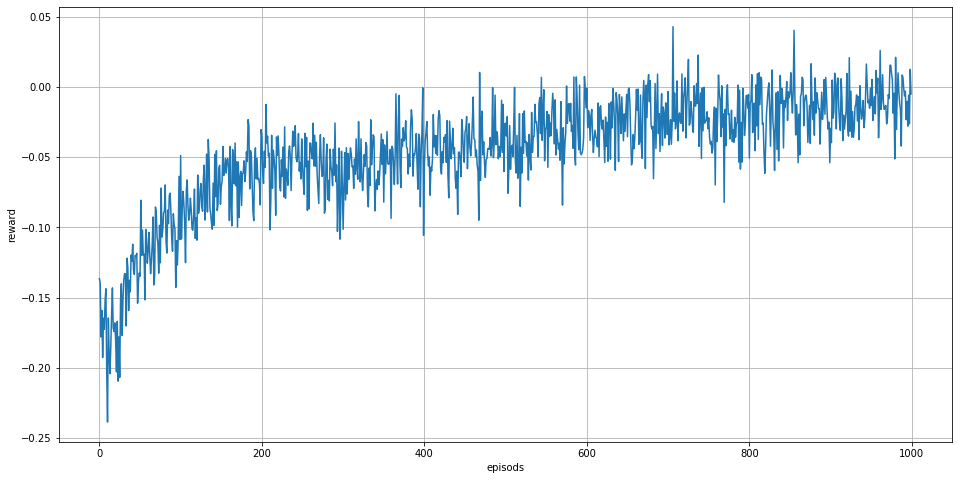

In [52]:
plot_learinig(env, A, alpha=4e-05, epsilon=0.9)